0. Import stuff

1. Load model
    - a) The RNN class and functions it uses
    - b) Load the model
 
2. Load the data set
    - that has been saved 
    - a) training set
    - b) test set
        - The test set should have the same amount of KG context as in the training set
 
3. Training
    - a) Training function
    - b) Run the training
    - c) Plot the losses from training 
    - d) Save the trained model

4. Testing
    - a) Test function
    - b) Call the function and display / save results

### 0

In [4]:
import os
import random
import requests
import numpy as np

from gensim.models import KeyedVectors
import logging

from gensim import utils
import nltk

import networkx as nx
import matplotlib.pyplot as plt

import shutil
import smart_open
import sys 

from sys import platform
import random
import tensorflow as tf
import json

import time
import pickle

### 1

#### a)

In [2]:
TINY = 1e-6
ONE = tf.constant(1.)
NAMESPACE = 'rnn'
forbidden_weight = 1.
_weight_for_positive_matches = 1.
_rw = 1e-1


class RNN(object):
    _nodes_vocab_size = 300 * 3
    _question_vocab_size = 300
    _question_vector_size = 150
    _types_size = 3
    _mask_size = 200
    _types_proj_size = 5
    _word_proj_size = 50
    _word_proj_size_for_rnn = 50
    _word_proj_size_for_item = 50
    _internal_proj_size = 250
    _hidden_layer1_size = 250
    _hidden_layer2_size = 250
    _output_size = 2

    _memory_dim = 100
    _stack_dimension = 2

    def __init__(self, dropout=1.0):
        tf.compat.v1.reset_default_graph()
        with tf.compat.v1.variable_scope(NAMESPACE):
            config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
            self.sess = tf.compat.v1.Session(config=config)

            # Input variables
            self.node_X_fw = tf.compat.v1.placeholder(tf.float32, shape=(None, None, self._nodes_vocab_size), name='node_X_fw')
            self.node_X_bw = tf.compat.v1.placeholder(tf.float32, shape=(None, None, self._nodes_vocab_size), name='node_X_bw')
            self.question_vectors_fw = tf.compat.v1.placeholder(tf.float32, shape=(None, None, self._question_vocab_size),
                                                      name='question_vectors_inp_fw')
            self.question_vectors_bw = tf.compat.v1.placeholder(tf.float32, shape=(None, None, self._question_vocab_size),
                                                      name='question_vectors_inp_nw')
            self.question_mask = tf.compat.v1.placeholder(tf.float32, shape=(None, None, self._mask_size),
                                                name='question_mask')

            # The question is pre-processed by a bi-GRU
            self.Wq = tf.Variable(tf.compat.v1.random_uniform([self._question_vocab_size,
                                                     self._word_proj_size_for_rnn], -_rw, _rw))
            self.bq = tf.Variable(tf.compat.v1.random_uniform([self._word_proj_size_for_rnn], -_rw, _rw))
            self.internal_projection = lambda x: tf.nn.relu(tf.matmul(x, self.Wq) + self.bq)
            self.question_int_fw = tf.map_fn(self.internal_projection, self.question_vectors_fw)
            self.question_int_bw = tf.map_fn(self.internal_projection, self.question_vectors_bw)

            self.rnn_cell_fw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([tf.compat.v1.nn.rnn_cell.GRUCell(self._memory_dim) for _ in range(self._stack_dimension)],
                                                state_is_tuple=True)
            self.rnn_cell_bw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([tf.compat.v1.nn.rnn_cell.GRUCell(self._memory_dim) for _ in range(self._stack_dimension)],
                                                state_is_tuple=True)
            with tf.compat.v1.variable_scope('fw'):
                output_fw, state_fw = tf.compat.v1.nn.dynamic_rnn(self.rnn_cell_fw, self.question_int_fw, time_major=True,
                                                        dtype=tf.float32)
            with tf.compat.v1.variable_scope('bw'):
                output_bw, state_bw = tf.compat.v1.nn.dynamic_rnn(self.rnn_cell_bw, self.question_int_bw, time_major=True,
                                                        dtype=tf.float32)

            self.states = tf.concat(values=[output_fw, tf.reverse(output_bw, [0])], axis=2)
            self.question_vector_pre = tf.reduce_mean(tf.multiply(self.question_mask, self.states), axis=0)
            self.Wqa = tf.Variable(
                tf.compat.v1.random_uniform([2 * self._memory_dim, self._question_vector_size], -_rw, _rw),
                name='Wqa')
            self.bqa = tf.Variable(tf.compat.v1.random_uniform([self._question_vector_size], -_rw, _rw), name='bqa')
            self.question_vector = tf.nn.relu(tf.matmul(self.question_vector_pre, self.Wqa) + self.bqa)

            # bi-LSTM of triplets part
            self.Wtri = tf.Variable(tf.compat.v1.random_uniform([self._nodes_vocab_size,
                                                       self._word_proj_size_for_rnn], -_rw, _rw))
            self.btri = tf.Variable(tf.compat.v1.random_uniform([self._word_proj_size_for_rnn], -_rw, _rw))
            self.internal_projection = lambda x: tf.nn.relu(tf.matmul(x, self.Wtri) + self.btri)
            self.node_int_fw = tf.map_fn(self.internal_projection, self.node_X_fw)
            self.node_int_bw = tf.map_fn(self.internal_projection, self.node_X_bw)

            self.rnn_cell_fw_tri = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                [tf.compat.v1.nn.rnn_cell.GRUCell(self._memory_dim) for _ in range(self._stack_dimension)],
                state_is_tuple=True)
            self.rnn_cell_bw_tri = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                [tf.compat.v1.nn.rnn_cell.GRUCell(self._memory_dim) for _ in range(self._stack_dimension)],
                state_is_tuple=True)
            with tf.compat.v1.variable_scope('fw_tri'):
                output_fw_tri, _ = tf.compat.v1.nn.dynamic_rnn(self.rnn_cell_fw_tri, self.node_int_fw, time_major=True,
                                                     dtype=tf.float32)
            with tf.compat.v1.variable_scope('bw_tri'):
                output_bw_tri, _ = tf.compat.v1.nn.dynamic_rnn(self.rnn_cell_bw_tri, self.node_int_bw, time_major=True,
                                                     dtype=tf.float32)

            self.states_tri = tf.concat(values=[output_fw_tri, output_bw_tri], axis=2)

            self.Walpha = tf.Variable(tf.compat.v1.random_uniform([2 * self._memory_dim + self._question_vector_size,
                                                         1], -_rw, _rw))
            self.balpha = tf.Variable(tf.compat.v1.random_uniform([1], -_rw, _rw))
            self.alpha_projection = lambda x: tf.nn.relu(tf.matmul(tf.concat(values=[x, self.question_vector], axis=1),
                                                                   self.Walpha) + self.balpha)
            self.alphas = tf.map_fn(self.alpha_projection, self.states_tri)
            self.alphas = tf.compat.v1.nn.softmax(self.alphas, dim =0)
            self.centroid = tf.reduce_mean(tf.multiply(self.states_tri, self.alphas), axis=0)

            self.concatenated = tf.concat(values=[self.question_vector, self.centroid], axis=1)

            # Final feedforward layers
            self.Ws1 = tf.Variable(
                tf.compat.v1.random_uniform([self._question_vector_size
                                   + 2 * self._memory_dim,
                                   self._hidden_layer2_size], -_rw, _rw),
                name='Ws1')
            self.bs1 = tf.Variable(tf.compat.v1.random_uniform([self._hidden_layer2_size], -_rw, _rw), name='bs1')
            self.first_hidden = tf.nn.relu(tf.matmul(self.concatenated, self.Ws1) + self.bs1)
            self.first_hidden_dropout = tf.nn.dropout(self.first_hidden, dropout)

            self.Wf = tf.Variable(
                tf.compat.v1.random_uniform([self._hidden_layer2_size, self._output_size], -_rw,
                                  _rw),
                name='Wf')
            self.bf = tf.Variable(tf.compat.v1.random_uniform([self._output_size], -_rw, _rw), name='bf')
            self.outputs = tf.nn.softmax(tf.matmul(self.first_hidden_dropout, self.Wf) + self.bf)

            # Loss function and training
            self.y_ = tf.compat.v1.placeholder(tf.float32, shape=(None, self._output_size), name='y_')
            self.outputs2 = tf.squeeze(self.outputs)
            self.y2_ = tf.squeeze(self.y_)
            self.one = tf.ones_like(self.outputs)
            self.tiny = self.one * TINY
            self.cross_entropy = (tf.reduce_mean(
                -tf.reduce_sum(self.y_ * tf.compat.v1.log(self.outputs + self.tiny) * _weight_for_positive_matches
                               + (self.one - self.y_) * tf.compat.v1.log(
                    self.one - self.outputs + self.tiny))
            ))

        # Clipping the gradient
        optimizer = tf.compat.v1.train.AdamOptimizer(1e-4)
        gvs = optimizer.compute_gradients(self.cross_entropy)
        capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs if var.name.find(NAMESPACE) != -1]
        self.train_step = optimizer.apply_gradients(capped_gvs)
        self.sess.run(tf.compat.v1.global_variables_initializer())

        # Adding the summaries
        tf.compat.v1.summary.scalar('cross_entropy', self.cross_entropy)
        self.merged = tf.compat.v1.summary.merge_all(key=tf.compat.v1.GraphKeys.SUMMARIES)
        self.train_writer = tf.compat.v1.summary.FileWriter('./train', self.sess.graph)

    def __train(self, node_X, item_vector, question_vectors, question_mask, y):
        node_X_fw = np.array(node_X)
        node_X_fw = np.transpose(node_X_fw, (1, 0, 2))
        node_X_bw = node_X_fw[::-1, :, :]

        question_vectors = np.array(question_vectors)
        question_vectors_fw = np.transpose(question_vectors, (1, 0, 2))
        question_vectors_bw = question_vectors_fw[::-1, :, :]

        question_mask = np.array(question_mask)
        question_mask = np.transpose(question_mask, (1, 0, 2))

        y = np.array(y)

        feed_dict = {}
        feed_dict.update({self.node_X_fw: node_X_fw})
        feed_dict.update({self.node_X_bw: node_X_bw})
        feed_dict.update({self.question_vectors_fw: question_vectors_fw})
        feed_dict.update({self.question_vectors_bw: question_vectors_bw})
        feed_dict.update({self.question_mask: question_mask})
        feed_dict.update({self.y_: y})

        loss, _,  outputs2, y2 = self.sess.run(
            [self.cross_entropy, self.train_step, self.outputs2, self.y2_], feed_dict)
        return loss

    def train(self, data, epochs=20):
        
        for epoch in range(epochs):
            loss = self.__train([data[i][0] for i in range(len(data))],
                                   [data[i][1] for i in range(len(data))],
                                   [data[i][2] for i in range(len(data))],
                                   [data[i][3] for i in range(len(data))],
                                   [data[i][4] for i in range(len(data))])

            sys.stdout.flush()
        return loss
    def __predict(self, node_X, item_vector, question_vectors, question_mask):
        
        node_X_fw = np.array(node_X)
        node_X_fw = np.transpose(node_X_fw, (1, 0, 2))
        node_X_bw = node_X_fw[::-1, :, :]

        question_vectors = np.array(question_vectors)
        question_vectors_fw = np.transpose(question_vectors, (1, 0, 2))
        question_vectors_bw = question_vectors_fw[::-1, :, :]

        question_mask = np.array(question_mask)
        question_mask = np.transpose(question_mask, (1, 0, 2))

        feed_dict = {}
        feed_dict.update({self.node_X_fw: node_X_fw})
        feed_dict.update({self.node_X_bw: node_X_bw})

        feed_dict.update({self.question_vectors_fw: question_vectors_fw})
        feed_dict.update({self.question_vectors_bw: question_vectors_bw})
        feed_dict.update({self.question_mask: question_mask})

        y_batch = self.sess.run([self.outputs2], feed_dict)
        return y_batch

    def __standardize_item(self, item):
        if item[0] < item[1]:
            return [0., 1.]
        return [1., 0.]

    def predict(self, node_X, item_vector, question_vectors, question_mask):
        output = self.__predict([node_X], [item_vector], [question_vectors], [question_mask])
        return self.__standardize_item(output[0])

    # Loading and saving functions

    def save(self, filename):
        saver =  tf.compat.v1.train.Saver()
        saver.save(self.sess, filename)

    def load_tensorflow(self, filename):
        saver =  tf.compat.v1.train.Saver([v for v in tf.compat.v1.global_variables() if NAMESPACE in v.name])
        saver.restore(self.sess, filename)

    @classmethod
    def load(self, filename, dropout=1.0):
        model = GCN_QA(dropout)
        model.load_tensorflow(filename)
        return model


b) 

In [7]:
tf.compat.v1.disable_eager_execution()

print('Loading model: ')
RNN_with_attention_100 = RNN(dropout=0.25)

Loading model: 
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
dim is deprecated, use axis instead


Load a model to train on max 400 node subgraph

In [3]:
tf.compat.v1.disable_eager_execution()

print('Loading model: ')
RNN_with_attention_400 = RNN(dropout=0.25)

Loading model: 
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
dim is deprecated, use axis instead


### 2

a)

In [11]:


# pickle file, saved from running the make_training_set_wikidata notebook
current_training_set =  'training_data_rnn_9713_100.pickle'

# 'training_data_rnn_39106_10.pickle'

with open(current_training_set, 'rb') as handle:
    training_data = pickle.load(handle)

Select the first 5000 entities from the full training set, to train on.

It had 39106 rows (19503 entities that worked)

max 400 training set

In [5]:
current_training_set =  'training_data_rnn_9743_400.pickle'

# 'training_data_rnn_39106_10.pickle'

with open(current_training_set, 'rb') as handle:
    training_data_400 = pickle.load(handle)

 

b)

In [9]:
# pickle file, saved from running the make_training_set_wikidata notebook
   # name has model, number of entities and number of nodes
import pickle    
current_test_set =  'test_data_rnn_1944_400.pickle'
with open(current_test_set, 'rb') as handle:
    test_set = pickle.load(handle)

In [13]:
# pickle file, saved from running the make_training_set_wikidata notebook
   # name has model, number of entities and number of nodes

current_test_set =  'test_data_rnn_1939_100.pickle'
with open(current_test_set, 'rb') as handle:
    test_set = pickle.load(handle)

### 3

#### a)

In [6]:
def get_chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def bin_data_into_buckets(data, batch_size):
    buckets = []
    size_to_data_dict = {}
    for item in data:
        seq_length = len(item['graph']['vectors'])
        question_length = len(item['question_vectors'])
        try:
            size_to_data_dict[(seq_length, question_length)].append(item)
        except:
            size_to_data_dict[(seq_length, question_length)] = [item]
    for key in size_to_data_dict.keys():
        data = size_to_data_dict[key]
        chunks = get_chunks(data, batch_size)
        for chunk in chunks:
            buckets.append(chunk)
    return buckets


def train_rnn(data, model, saving_dir, name_prefix, epochs=20, bucket_size=10, trace_every=1):
    buckets = bin_data_into_buckets(data, bucket_size)
    losses = []
    
    start_time = time.time()


    for i in range(epochs):
        random_buckets = sorted(buckets, key=lambda x: random.random())
        sys.stderr.write('--------- Epoch ' + str(i) + ' ---------\n')
        sys.stderr.write('time_elapsed (s): ' + str(time.time() - start_time) + '\n')
       
        for bucket in random_buckets:
            graph_bucket = []
#             try:
            for item in bucket:
                node_vectors = item['graph']['vectors']
                y = item['answer']
                item_vector = item['item_vector']
                question_vectors = item['question_vectors']
                question_mask = item['question_mask']
#                 print('node_vector: {}'.format(type(node_vectors)))
#                 print('y: {}'.format(y))
#                 print('item_vector: {}'.format(type(item_vector)))
#                 print('question_vectors: {}'.format(type(question_vectors)))
#                 print('question_mask: {}'.format(type(question_mask)))
#                 break
                graph_bucket.append((node_vectors, item_vector, question_vectors, question_mask, y))
                
                
            if len(graph_bucket) > 0:
                loss = model.train(graph_bucket, 1)
                losses.append(loss)
#             except Exception as e:
#                 print('Exception caught during training: ' + str(e))
        if i % trace_every == 0:
            save_filename = saving_dir + name_prefix + '-' + str(i) + '.tf'
            sys.stderr.write('Saving into ' + save_filename + '\n')
            model.save(save_filename)
    return losses, buckets

#### b)

In [14]:
n_epochs = 90

_saving_dir = 'data/'
losses_ru, bucket = train_rnn(training_data,
      RNN_with_attention_100,
      _saving_dir,
      name_prefix='rnn',
      epochs=n_epochs,
      bucket_size=10,
      trace_every=1,
      )


--------- Epoch 0 ---------
time_elapsed (s): 0.0006959438323974609
Saving into data/rnn-0.tf
--------- Epoch 1 ---------
time_elapsed (s): 267.9810400009155
Saving into data/rnn-1.tf
--------- Epoch 2 ---------
time_elapsed (s): 511.6649122238159
Saving into data/rnn-2.tf
--------- Epoch 3 ---------
time_elapsed (s): 744.7121930122375
Saving into data/rnn-3.tf
--------- Epoch 4 ---------
time_elapsed (s): 977.31556391716
Saving into data/rnn-4.tf
--------- Epoch 5 ---------
time_elapsed (s): 1206.830137014389
Saving into data/rnn-5.tf
--------- Epoch 6 ---------
time_elapsed (s): 1435.1079289913177
Saving into data/rnn-6.tf
--------- Epoch 7 ---------
time_elapsed (s): 1666.308042049408
Saving into data/rnn-7.tf
--------- Epoch 8 ---------
time_elapsed (s): 1900.0522849559784
Saving into data/rnn-8.tf
--------- Epoch 9 ---------
time_elapsed (s): 2143.0867908000946
Saving into data/rnn-9.tf
--------- Epoch 10 ---------
time_elapsed (s): 2395.67049908638
Saving into data/rnn-10.tf
----

--------- Epoch 89 ---------
time_elapsed (s): 19674.66388988495
Saving into data/rnn-89.tf


trained on max 400 nodes

In [8]:
n_epochs = 14

_saving_dir = 'data/'
losses_ru, bucket = train_rnn(training_data_400,
      RNN_with_attention_400,
      _saving_dir,
      name_prefix='rnn',
      epochs=n_epochs,
      bucket_size=10,
      trace_every=1,
      )


--------- Epoch 0 ---------
time_elapsed (s): 0.002198934555053711
Saving into data/rnn-0.tf
--------- Epoch 1 ---------
time_elapsed (s): 1212.5825307369232
Saving into data/rnn-1.tf
--------- Epoch 2 ---------
time_elapsed (s): 2435.6520409584045
Saving into data/rnn-2.tf
--------- Epoch 3 ---------
time_elapsed (s): 3659.8572828769684
Saving into data/rnn-3.tf
--------- Epoch 4 ---------
time_elapsed (s): 4933.030325889587
Saving into data/rnn-4.tf
--------- Epoch 5 ---------
time_elapsed (s): 6168.8119328022
Saving into data/rnn-5.tf
--------- Epoch 6 ---------
time_elapsed (s): 7406.63069486618
Saving into data/rnn-6.tf
--------- Epoch 7 ---------
time_elapsed (s): 8582.185778856277
Saving into data/rnn-7.tf
--------- Epoch 8 ---------
time_elapsed (s): 9739.916426897049
Saving into data/rnn-8.tf
--------- Epoch 9 ---------
time_elapsed (s): 10905.071465015411
Saving into data/rnn-9.tf
--------- Epoch 10 ---------
time_elapsed (s): 12128.376188993454
Saving into data/rnn-10.tf
---

c) 

max 10 nodes

 10 epochs

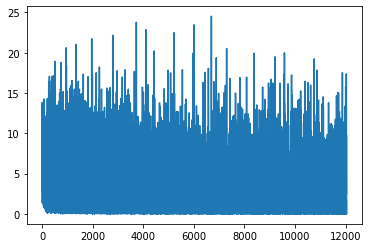

In [35]:
plt.plot(losses_ru)

25 epochs

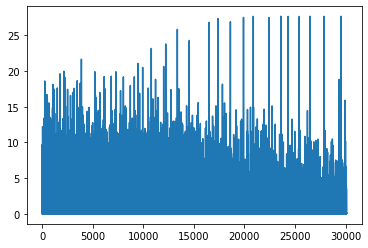

In [37]:
plt.plot(losses_ru)

60 epochs

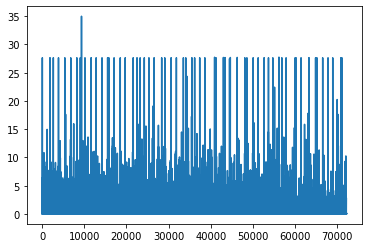

In [39]:
plt.plot(losses_ru)

100 nodes max, 90 epochs I think

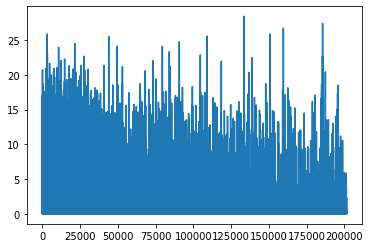

In [58]:
plt.plot(losses_ru)

400 nodes max,    90 epochs 

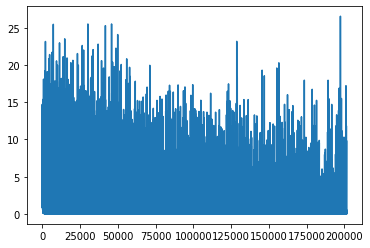

In [18]:
plt.plot(losses_ru)

### 4

In [11]:
_is_relevant = [.0, 1.]
_is_not_relevant = [1., 0.]

_logger = logging.getLogger(__name__)

def test(data, model):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for item in data:
        expected = item['answer']
        node_vectors = item['graph']['vectors']
        item_vector = item['item_vector']
        question_vectors = item['question_vectors']
        question_mask = item['question_mask']
#        try:
        prediction = model.predict(node_vectors, item_vector, question_vectors, question_mask)
        if prediction == expected and expected == _is_relevant:
            true_positives += 1
        if prediction == expected and expected == _is_not_relevant:
            true_negatives += 1
        if prediction != expected and expected == _is_relevant:
            false_negatives += 1
        if prediction != expected and expected == _is_not_relevant:
            false_positives += 1
#        except Exception as e:
#            print('Exception caught during training: ' + str(e))
    try:
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * 1 / (1 / precision + 1 / recall)
        print('precision', precision)
        print('recall', recall)
        print('f1', f1)
    except:
        print('Cannot compute precision and recall.')


### Test RNN trained on 10 node subgraphs

In [56]:
test(test_set,RNN_with_attention)

precision 0.5052192066805845
recall 0.24719101123595505
f1 0.33196159122085045


### Test RNN trained on 100 node subgraphs

In [16]:
# try testing the one trained on 100 on the 10 subgraph set

test(test_set,RNN_with_attention_100)

precision 0.9183457051961824
recall 0.8774062816616008
f1 0.8974093264248705


### Test RNN trained on 400 node subgraphs

Tested on 400 nodes

In [12]:
test(test_set,RNN_with_attention_400)

precision 0.8771929824561403
recall 0.9155645981688708
f1 0.8959681433549029


Tested on 100 nodes 

In [14]:
test(test_set,RNN_with_attention_400)

precision 0.8757281553398059
recall 0.9222903885480572
f1 0.898406374501992


Tested on 10 nodes 

In [15]:
# pickle file, saved from running the make_training_set_wikidata notebook
   # name has model, number of entities and number of nodes

current_test_set =  'test_data_rnn_1944_10.pickle'
with open(current_test_set, 'rb') as handle:
    test_set_10 = pickle.load(handle)
    
test(test_set_10,RNN_with_attention_400)    

precision 0.8726738491674828
recall 0.9101123595505618
f1 0.891
